In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Firstly, let's talk about the Sobel operator, which is the basic of the Canny.
Firstky, we should reduce the noise through the Gaussian filter, which would help to prevent to note the noise as the edge point and get the better results.

Next, When the image is smoothed, the derivatives Ix and Iy w.r.t. x and y are calculated

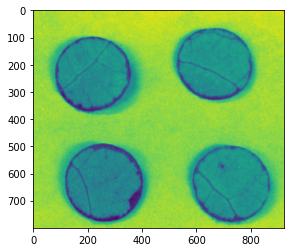

In [ ]:
import numpy as np
import cv2

image = cv2.imread("/content/drive/MyDrive/images/Lab2-image/1.png")
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image)
cv2.waitKey()


sobelX = cv2.Sobel(image,cv2.CV_64F,1,0)
sobelY = cv2.Sobel(image,cv2.CV_64F,0,1)

sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))

According to the gradient calculation, we could get two result from X direction and Y direction. We will gain two pictures based on different gradient calculation.

-1

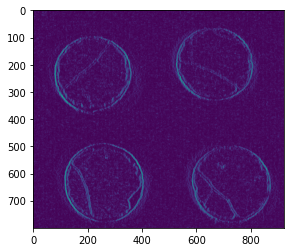

In [ ]:
sobelCombined = cv2.bitwise_or(sobelX,sobelY)#
plt.imshow(sobelX)
cv2.waitKey()

-1

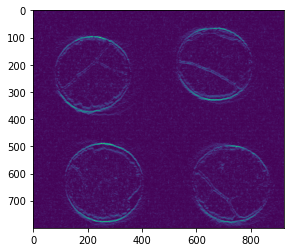

In [ ]:
plt.imshow(sobelY)
cv2.waitKey()

For the better result, we could combine both of them, it's obvious that we could get a better result.

-1

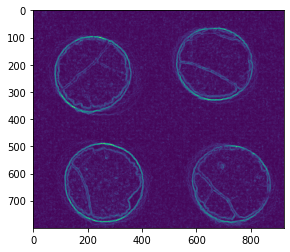

In [ ]:
plt.imshow(sobelCombined)
cv2.waitKey()

Now, lets's talk about the Canny. There is only one mainly different between the Canny and Sobel,that canny will do another process to promote the result: Non-Maximum Suppression.
Ideally, the final image should have thin edges. Thus, we must perform non-maximum suppression to thin out the edges.
The principle is simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.
From comparing the Fig10 and Fig11, after doing non-maximum suppression, the edge will be given greater prominence.

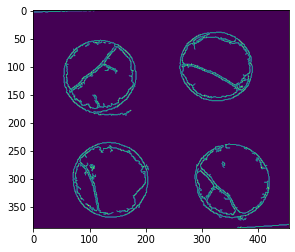

In [ ]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from numpy import ndarray
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import os
from PIL import Image

def canny(path):
  image = cv2.imread(path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  plt.imshow(image)
  cv2.waitKey()

  canny = cv2.Canny(image,30,150)
  plt.imshow(canny)
  cv2.waitKey()
  return canny

edge = canny("/content/drive/MyDrive/images/Lab2-image/origin/1.png")

In [ ]:
contours, hierarchy = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 5000]
print(len(contours))

area = 0.0
for a in range(0,len(contours)):  
    area = area + cv2.contourArea(contours[a])

print(edge.size)
print(area)
print(area/edge.size)

4
176928
43371.5
0.24513643968167842


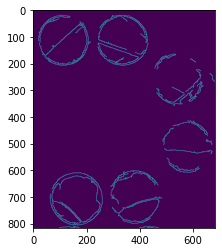

In [ ]:
edge = canny("/content/drive/MyDrive/images/Lab2-image/2.png")

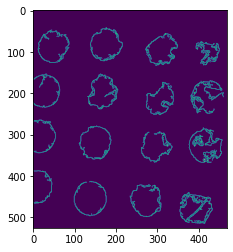

In [ ]:
edge = canny("/content/drive/MyDrive/images/Lab2-image/3.png")

#Learning

In [ ]:
from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final


In [ ]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import scipy.misc as sm


def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


def load_data(faces_imgs):
    '''
    Load images from the "faces_imgs" directory
    Images are in JPG and we convert it to gray scale images
    '''
    imgs = []
    for filename in os.listdir(faces_imgs):
        if os.path.isfile(faces_imgs + '/content/drive/MyDrive/images/Lab2-image' + 2):
            img = mpimg.imread(faces_imgs + '/content/drive/MyDrive/images/Lab2-image' + 2)
            img = rgb2gray(img)
            imgs.append(img)
    return imgs

def visualize(imgs, format=None, gray=False):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1, 2, 0)
        plt_idx = i + 1
        plt.subplot(2, 2, plt_idx)
        plt.imshow(img, format)
    plt.show()
